In [2]:
!pip install faker
!pip install tqdm
!pip install keras_preprocessing
!pip install keras

In [3]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

from faker import Faker
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [4]:
#Variablen
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

# Funktionen

In [5]:
# Function to viz the annotation

BildGrößeX = 512
BildGrößeY = 512

def markup(BildWeg, annotations):
  # laden der Zusatdaten
  Bild = cv2.imread(BildWeg)
  x_sl = BildGrößeX/Bild.shape[1]
  y_sl = BildGrößeY/Bild.shape[0]

  Bild = cv2.resize(Bild, (BildGrößeX, BildGrößeY))

  # laden der Infos
  Y = np.zeros((grid_h,grid_w,1,5))

  for annotation in annotations:
      # "bbox": [37.59, 433.64, 251.07, 20.38]
    xmin = annotation['bbox'][0] * x_sl
    xmax = (annotation['bbox'][0] + annotation['bbox'][2]) * x_sl

    ymin = annotation['bbox'][1] * y_sl
    ymax = (annotation['bbox'][1] + annotation['bbox'][3]) * y_sl
    
    w = (xmax - xmin)/BildGrößeX
    h = (ymax - ymin)/BildGrößeY
    
    x = ((xmax + xmin)/2)/BildGrößeX
    y = ((ymax + ymin)/2)/BildGrößeY
    x = x * grid_w
    y = y * grid_h

    Y[int(y),int(x),0,0] = 1
    Y[int(y),int(x),0,1] = x - int(x)
    Y[int(y),int(x),0,2] = y - int(y)
    Y[int(y),int(x),0,3] = w
    Y[int(y),int(x),0,4] = h

  return Bild, Y

In [6]:

import numpy as np
import os
import tensorflow as tf
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt

def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.2
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    return final_boxes,scores

def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou

def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    
    return final

def decode(output , ht , wd , iou):    
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    boxes = non_max(boxes,np.array(scores) , iou)
    return boxes

# Model Funktionen


In [7]:
def yolo_model(input_shape):
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same', name="ErstesCNNLayer")(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same', name="ZweitesCNNLayer")(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info), name="Finale")(conv)
    
    model = Model(inp,final)
    
    return model

In [8]:
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

# Model Bau

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

csv_logger = CSVLogger('log.csv', append=True, separator=';')

#checkpoint
checkpoint = ModelCheckpoint('model1/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [10]:
model = yolo_model((512,512,3))

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


# Training


In [11]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()
  print(Name + " entpacked")


In [12]:
x = []
y = []

In [12]:
# Daten Laden
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/val.tar.gz --output "val.tar.gz"
openTar("val.tar.gz")
!rm val.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-1.tar.gz --output "train-1.tar.gz"
#openTar("train-1.tar.gz")
#!rm train-1.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz --output "train-0.tar.gz"
#openTar("train-0.tar.gz")
#!rm train-0.tar.gz

#!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-2.tar.gz --output "train-2.tar.gz"
#openTar("train-2.tar.gz")
#!rm train-2.tar.gz

!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"
openTar("labels.tar.gz")
!rm labels.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3106M  100 3106M    0     0  11.2M      0  0:04:35  0:04:35 --:--:-- 10.4M
val.tar.gz entpacked
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  65.5M      0  0:00:04  0:00:04 --:--:-- 71.3M
labels.tar.gz entpacked


In [13]:
StringToJson = 'publaynet/val.json'
StringToFolder = 'publaynet/val/'

NumberPerTirm = 3000

# 335,703 Bilder

In [19]:
testArray = []

with open(StringToJson, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    testArray.append(image['id'])
    images[image['id']] = {'file_name': StringToFolder + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

NameError: ignored

In [26]:
def load(test):
  Train = []
  Lösung = []
  for i, (_, image) in enumerate(test.items()):
    try:
      TempImage, ZielMuster = markup(image['file_name'], image['annotations'])
      Train.append(TempImage)
      Lösung.append(ZielMuster)
    except Exception:
      continue

  Train = np.array(Train)
  Lösung = np.array(Lösung)
  return Train, Lösung

In [16]:
# model = keras.models.load_model('model1000')

In [ ]:
max_Loss = 1000000

for p in range(0,335703,NumberPerTirm):
  print("\n\nStarte bei Bild --------------- " + str(p))

  test = {}
  for _ in range(NumberPerTirm):
    id = testArray.pop(0)
    test[id] = images[id]

  x,y = load(test)

  hist = model.fit(x, y, epochs= 5 ,batch_size = 4, validation_split=0.2, callbacks=[csv_logger])
  if (hist['loss']>max_Loss):
    break
  max_Loss = hist['loss']

  model.save('model' + str(p))
  

Starte bei Bild --------------- 0
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 63s 79ms/step - loss: 0.4244 - accuracy: 0.9476 - val_loss: 0.2566 - val_accuracy: 0.9631
Epoch 2/5
800/800 [==============================] - 44s 55ms/step - loss: 0.3149 - accuracy: 0.9601 - val_loss: 0.2786 - val_accuracy: 0.9631
Epoch 3/5
800/800 [==============================] - 44s 55ms/step - loss: 0.3109 - accuracy: 0.9598 - val_loss: 0.2824 - val_accuracy: 0.9631
Epoch 4/5
800/800 [==============================] - 44s 55ms/step - loss: 0.3148 - accuracy: 0.9602 - val_loss: 0.2870 - val_accuracy: 0.9631
Epoch 5/5
800/800 [==============================] - 44s 55ms/step - loss: 0.3140 - accuracy: 0.9602 - val_loss: 0.2326 - val_accuracy: 0.9621
Starte bei Bild --------------- 1000
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 44s 55ms/step - loss: 0.3088 - accuracy: 0.9600 - val_loss: 0.2437 - 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-bdffa897e3e8>", line 11, in <module>
    model.fit(x, y, epochs= 5 ,batch_size = 4, validation_split=0.2, callbacks=[csv_logger])
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3800, in __call__
    [x._numpy() for x in outputs],  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3800, in <listcomp>
    [x._numpy() for x in outputs],  # pylint: disable=protected-access
  File "/usr/local/lib/py

KeyboardInterrupt: ignored

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 661, in _abort_queue
    pol

# Auswertung


In [13]:
plt.xkcd()

In [14]:
import csv

Model_epoch = []
accuracy = []
loss = []
val_accurecy = []
val_loss = []

with open('log.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    header = next(spamreader)
    for row in spamreader:
         Wert = row[0]
         Model_epoch.append(float(Wert))
         Wert = row[1]
         accuracy.append(float(Wert))
         Wert = row[2]
         loss.append(float(Wert))
         Wert = row[3]
         val_accurecy.append(float(Wert))
         Wert = row[4]
         val_loss.append(float(Wert))

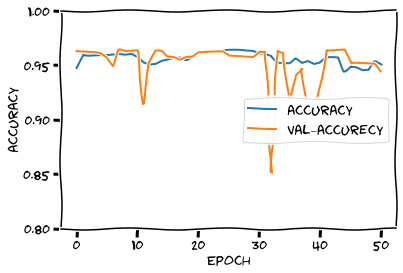

In [15]:
plt.plot(accuracy, label = 'accuracy')
plt.plot(val_accurecy, label = 'val_accurecy')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='center right')
plt.show()

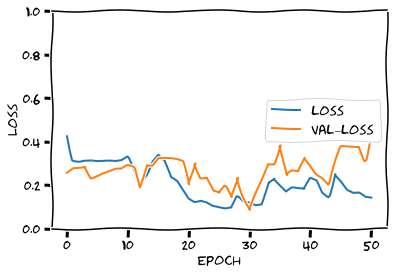

In [16]:
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

# Analyse

In [28]:
# Daten Laden
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"

openTar("examples.tar.gz")

StringToJSON = 'examples/samples.json'
StringToFolder = 'examples/'

with open(StringToJSON, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    testArray.append(image['id'])
    images[image['id']] = {'file_name': StringToFolder + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

x,y = load(images)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6309k  100 6309k    0     0  19.6M      0 --:--:-- --:--:-- --:--:-- 19.6M
examples.tar.gz entpacked


In [24]:
model = keras.models.load_model('model5000')

In [30]:
import os
from matplotlib.pyplot import figure

def predict_func(model , inp , iou , name, test):

    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    ans = model.predict(inp)
    ans = test
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]

    #plt.imshow(img)
    #plt.show()

    print(len(boxes))

    for i in boxes:

        i = [int(x) for x in i]
        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 3)

    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


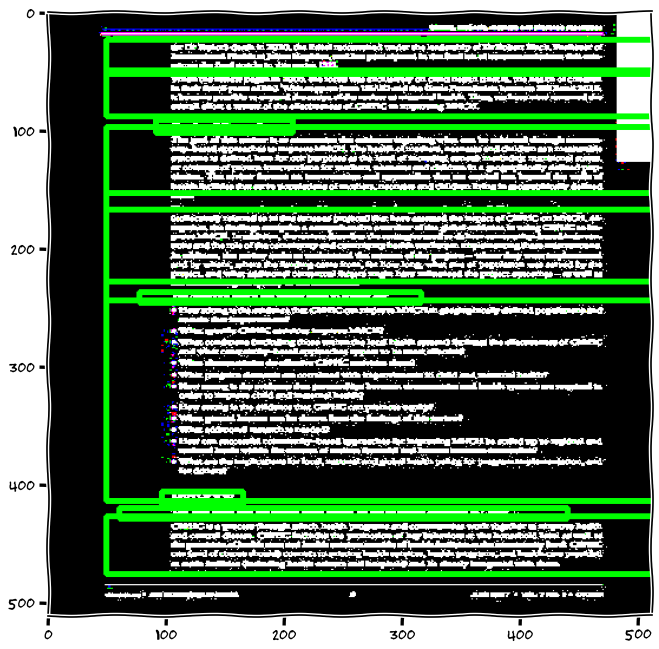

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


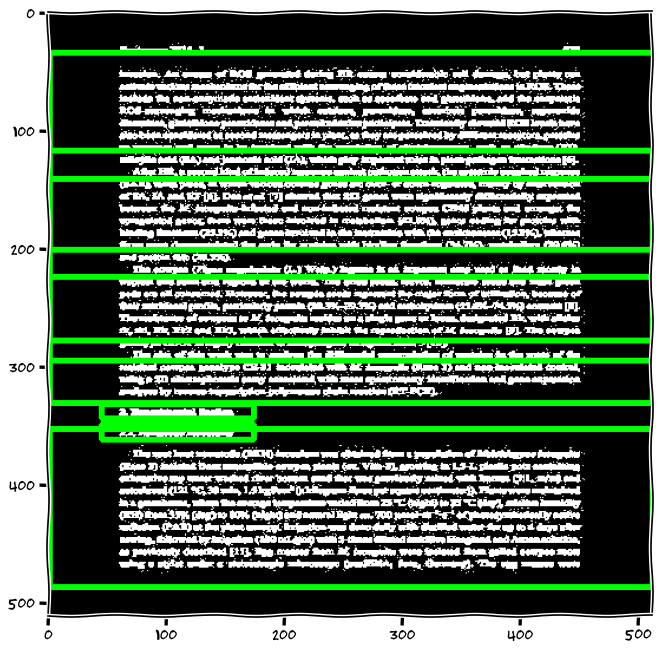

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


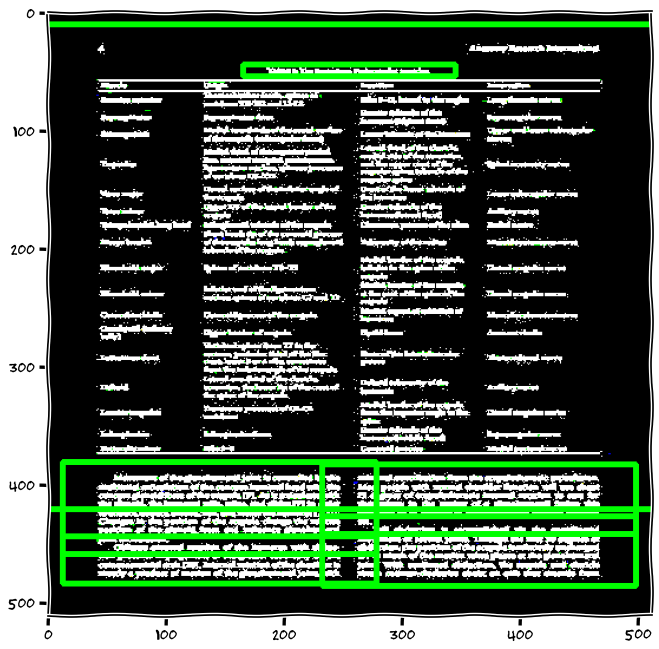

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


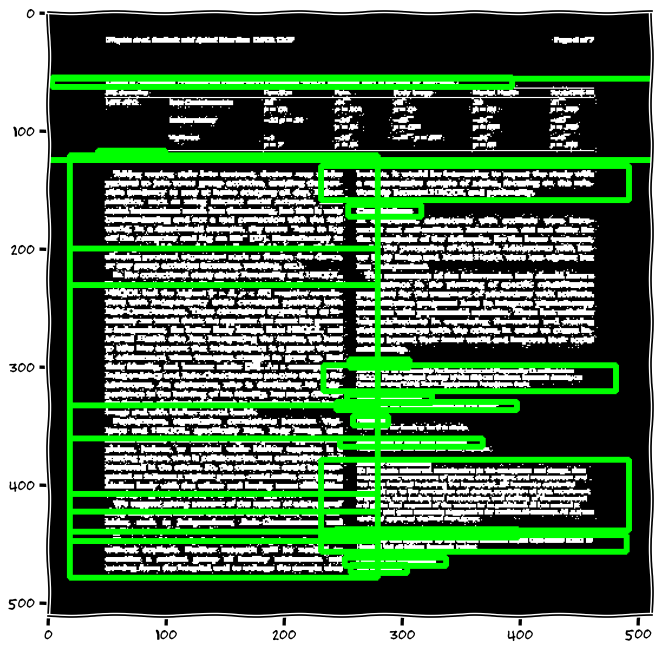

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


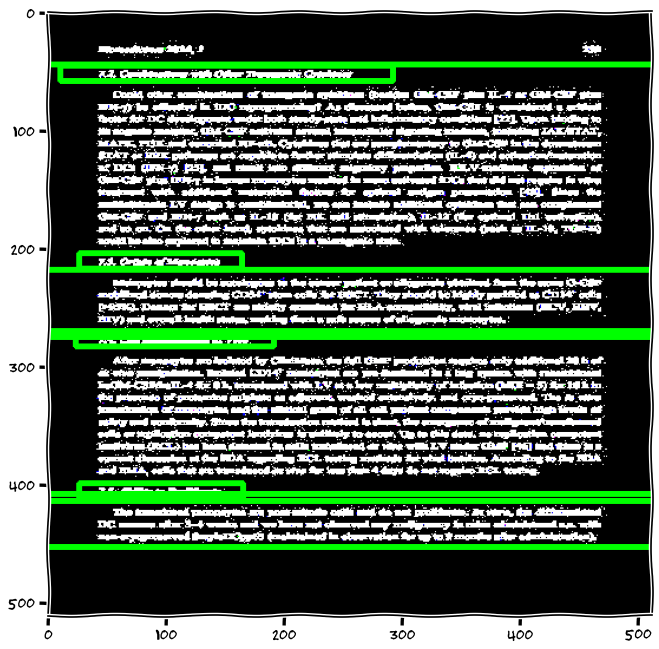

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


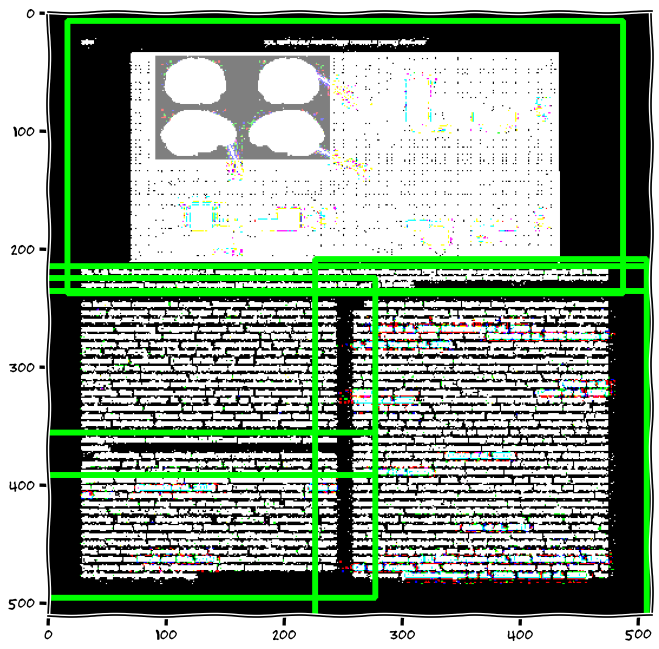

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


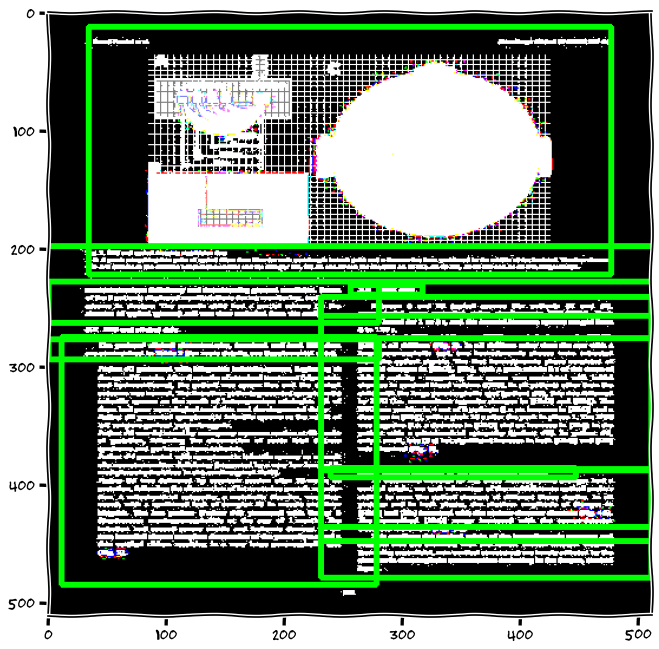

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


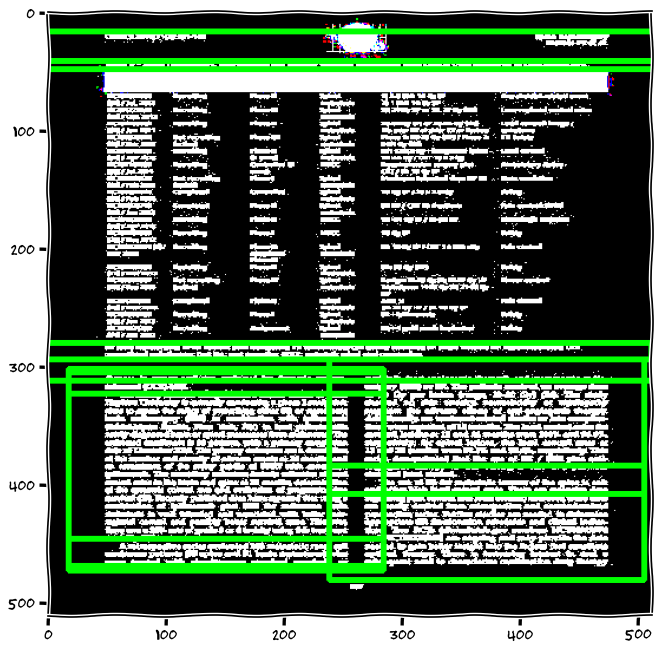

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


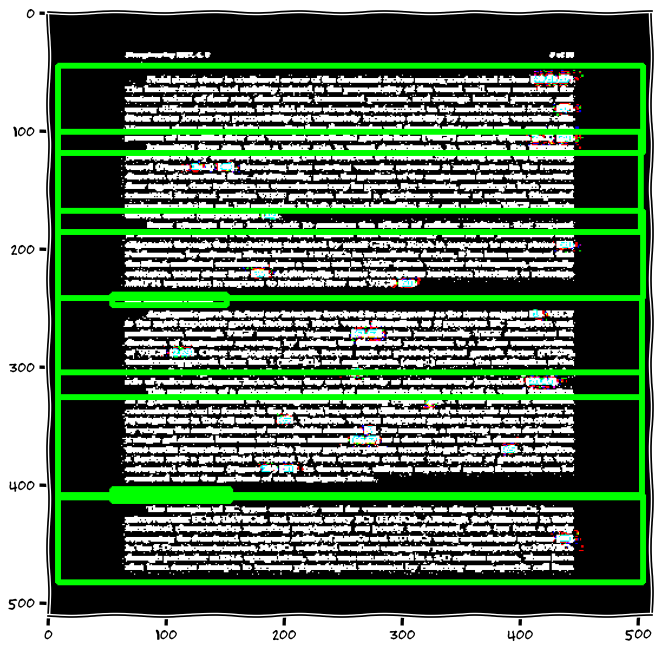

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


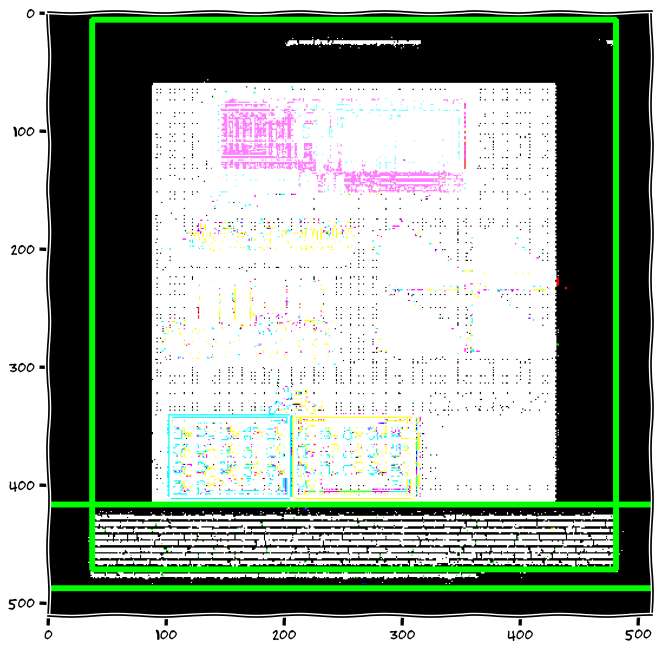

In [31]:
for i in range(10):
  temp = x[i:i+1]
  test = y[i:i+1]
  predict_func(model, temp, 0.5, str(i), test)